In [ ]:
'''
Alex Costanzino, Xiaowei Wen
MSc student in Artificial Intelligence
@ Alma Mater Studiorum, University of Bologna
June, 2021
'''

# **Bayesian Network Model for Diagnosis of Psychiatric Diseases**
*Fundamentals of Artificial Intelligence and Knowledge Representation - Mod. 3*

Because of numerous possible causes involved, it isn't easy for general physicians to identify the precise reason of the psychiatric diseases and to decide the correct treatment. 
Bayesian networks are recognized as efficient graphical models with significant capabilities for investigating biomedical data either to obtain relationships between variables, either for medical predictions.

## Libraries and imports

In [1]:
import sys
!{sys.executable} -m pip install pgmpy
!{sys.executable} -m pip install --upgrade pip

You should consider upgrading via the 'c:\users\wxw85\appdata\local\programs\python\python37\python.exe -m pip install --upgrade pip' command.


  Attempting uninstall: pip
    Found existing installation: pip 21.1.2
    Uninstalling pip-21.1.2:
      Successfully uninstalled pip-21.1.2


In [2]:
from pgmpy.models import BayesianModel
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

from pgmpy.sampling import BayesianModelSampling
from pgmpy.factors.discrete import State
from pgmpy.sampling import GibbsSampling

## 1. Model
**Bayesian networks** are data structures used to represent dependencies among variables. They can easily represents any full joint probability distribution in a concise way.

A bayesian network is a directed graph in which each node is annotated with quantitative probability information:
* Each node corresponds to a random variable, which may be discrete or continuous;
* A set of directed links connects pairs of nodes. If there is a link from node $X$ to node $Y$, $X$ is said to be *parent* of $Y$. The graph has no directed cycles (it is, indeed, a directed acyclic graph, or DAG);
* Each node $X_i$ has a conditional probability distribution $P(X_i | \text{Parents}(X_i))$ that quantifies the effect of the parents on the node.

The topology of the network specifies the conditional independence relationships that hold in the domain.

| Node Name | Paper Variable Number|
------------ | -------------
| Sex |  X1 |  
| Nr. of Parents suffering from schizophrenia  | X2 |  
| Mother with virosis during pregnancy|  X12  |  
| Genetic Influence schizophrenia   |  X11  |  
| Simple Schizophrenia  | X14  |  
| Social life deterioration|  X20  |  
| Grimaces, Mannerisms, puerility| X19  |   


### 1.1 Nodes name definition

In [3]:
sex = 'Sex'
parents = 'Parents suffering from schizophrenia'
mother_with_virosis = 'Mother with virosis during pregnancy'
genetic_influence = 'Genetic influence'
simple_schizophrenia = 'Simple schizophrenia'
social_life_deterioration = 'Social life deterioration'
mannerism = 'Mannerism'
personality_deterioration = 'Personality deterioration'

variables = [sex, parents, mother_with_virosis, genetic_influence, simple_schizophrenia, social_life_deterioration, mannerism, personality_deterioration]

### 1.2 Model definition

In [4]:
model = BayesianModel([(mother_with_virosis, simple_schizophrenia),
                       (parents, genetic_influence),
                       (sex, genetic_influence),
                       (genetic_influence, simple_schizophrenia),
                       (simple_schizophrenia, personality_deterioration),
                       (simple_schizophrenia, social_life_deterioration),
                       (simple_schizophrenia, mannerism)])

nodes = list(model.nodes())
edges = list(model.edges())

print('The nodes of the net are: {}'.format(nodes))
print('The edges of the net are: {}'.format(edges))

The nodes of the net are: ['Mother with virosis during pregnancy', 'Simple schizophrenia', 'Parents suffering from schizophrenia', 'Genetic influence', 'Sex', 'Personality deterioration', 'Social life deterioration', 'Mannerism']
The edges of the net are: [('Mother with virosis during pregnancy', 'Simple schizophrenia'), ('Simple schizophrenia', 'Personality deterioration'), ('Simple schizophrenia', 'Social life deterioration'), ('Simple schizophrenia', 'Mannerism'), ('Parents suffering from schizophrenia', 'Genetic influence'), ('Genetic influence', 'Simple schizophrenia'), ('Sex', 'Genetic influence')]


### 1.3 Model representation

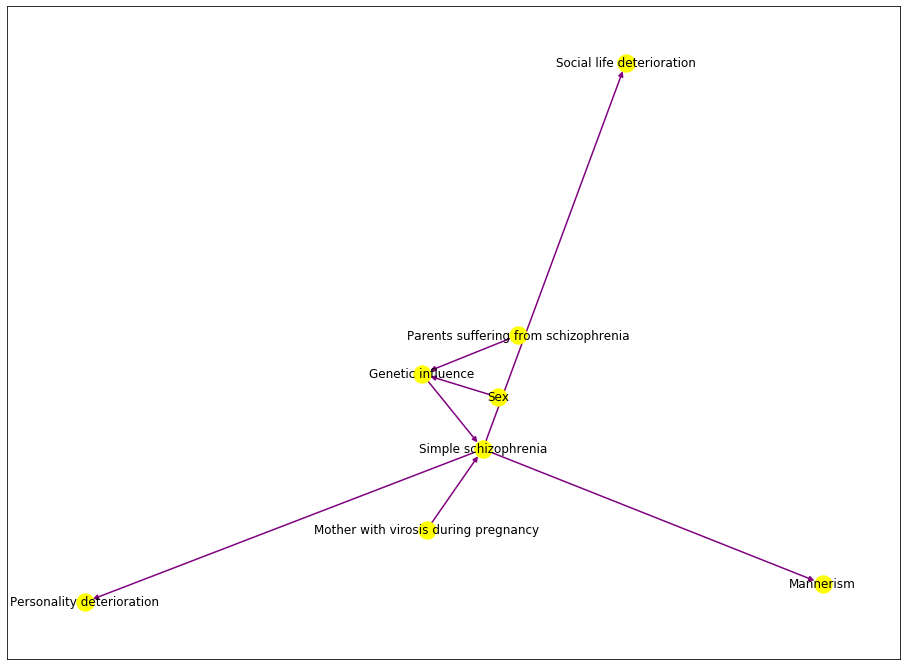

In [5]:
DAG = nx.DiGraph()
DAG.add_edges_from(edges)

fig = plt.figure(figsize = (16,12))
pos = nx.spring_layout(DAG) 

nx.draw_networkx_nodes(DAG, pos = pos, node_color = 'yellow')
nx.draw_networkx_labels(DAG, pos = pos)
nx.draw_networkx_edges(DAG, pos = pos, edge_color = 'purple', width = 1.5, arrows = True)

plt.show()

### 1.4 Graph structure
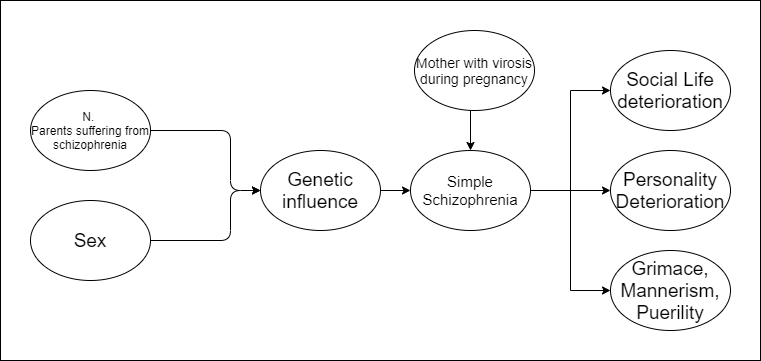

## 2. CPD definition
*Conditional probability distributions* (CPDs) are a form of tabular representation suitable for discrete variables.
Each row in a CPD contains the conditional probability of each node value for a conditioning case.

A conditioning case is just a possible combination of values for the parent nodes.

### 2.1 Simple CPD

In [6]:
cpds = {}

# P(X1)
cpd_sex = TabularCPD(variable = sex, 
                     variable_card = 2,
                     values = [[0.5], 
                               [0.5]],
                     state_names = {sex : ['Male', 'Female']})

print("Sex P(X1)")
print(cpd_sex)

cpds[sex] = cpd_sex

# P(X2)
cpd_parents = TabularCPD(variable = parents, 
                         variable_card = 3,
                         values = [[0.88], 
                                   [0.119],
                                   [0.001]],
                         state_names = {parents : ['Zero', 'One', 'Both']})

print("Parents suffering from schizophrenia P(X2)")
print(cpd_parents)

cpds[parents] = cpd_parents

# P(X12)
cpd_virosis = TabularCPD(variable = mother_with_virosis, 
                         variable_card = 2,
                         values = [[0.12], 
                                   [0.88]],
                         state_names = {mother_with_virosis : ['True', 'False']})

print("Mother with virosis during pregnancy P(X12)")
print(cpd_virosis)

cpds[mother_with_virosis] = cpd_virosis

Sex P(X1)
+-------------+-----+
| Sex(Male)   | 0.5 |
+-------------+-----+
| Sex(Female) | 0.5 |
+-------------+-----+
Parents suffering from schizophrenia P(X2)
+--------------------------------------------+-------+
| Parents suffering from schizophrenia(Zero) | 0.88  |
+--------------------------------------------+-------+
| Parents suffering from schizophrenia(One)  | 0.119 |
+--------------------------------------------+-------+
| Parents suffering from schizophrenia(Both) | 0.001 |
+--------------------------------------------+-------+
Mother with virosis during pregnancy P(X12)
+---------------------------------------------+------+
| Mother with virosis during pregnancy(True)  | 0.12 |
+---------------------------------------------+------+
| Mother with virosis during pregnancy(False) | 0.88 |
+---------------------------------------------+------+


### 2.2 CPD with evidence

In [7]:
# P(X11|X1,X2)
cpd_genetic_influence = TabularCPD(variable = genetic_influence,
                                   variable_card = 2,
                                   values = [[0.01, 0.05, 0.30, 0.01, 0.06, 0.46],
                                             [0.99, 0.95, 0.70, 0.99, 0.94, 0.54]],
                                   evidence = [sex, parents],
                                   evidence_card = [2,3],
                                   state_names = {genetic_influence:['True','False'],
                                                  sex : ['Male', 'Female'],
                                                  parents : ['Zero', 'One', 'Both']
                                                  }
                                   )

print("Genetic Influence P(X11|X1,X2)")
print(cpd_genetic_influence)

cpds[genetic_influence] = cpd_genetic_influence

# P(X14|X11,X12)
cpd_schizophrenia = TabularCPD(variable = simple_schizophrenia, 
                              variable_card = 2,
                              values = [[0.25, 0.15, 0.08, 0.01],
                                        [0.75, 0.85, 0.92, 0.99]],
                              evidence = [genetic_influence, mother_with_virosis],
                              evidence_card = [2,2],
                              state_names = {simple_schizophrenia : ['True', 'False'], 
                                             genetic_influence : ['True','False'], 
                                             mother_with_virosis : ['True', 'False']}
                              )

print("Simple Schizophrenia P(X14|X11,X12)")
print(cpd_schizophrenia)

cpds[simple_schizophrenia] = cpd_schizophrenia

# P(X19 | X14)
cpd_mannerism = TabularCPD(variable = mannerism, 
                           variable_card = 2,
                           values = [[0.85, 0.03],
                                     [0.15, 0.97]],
                           state_names = {mannerism : ['Present', 'Absent'], 
                                          simple_schizophrenia: ['True', 'False']},
                           evidence = [simple_schizophrenia],
                           evidence_card = [2]
                           )

print("Mannerism P(X19|X14)")
print(cpd_mannerism)

cpds[mannerism] = cpd_mannerism

# P(X20|X14)
cpd_social_life_deterioration = TabularCPD(variable=social_life_deterioration,
                     variable_card = 2,
                     values = [[0.88, 0.10],
                               [0.12, 0.90]],
                     evidence = [simple_schizophrenia],
                     evidence_card = [2],
                     state_names = {simple_schizophrenia : ['True', 'False'], 
                                    social_life_deterioration : ['Present', 'Absent']}
                     )

print("Social Life Deterioration P(X20|X14)")
print(cpd_social_life_deterioration)

cpds[social_life_deterioration] = cpd_social_life_deterioration

# P(X21|X14)
cpd_personality_deterioration = TabularCPD(variable=personality_deterioration,
                                           variable_card = 2,
                                           values = [[0.87, 0.05],
                                                     [0.13, 0.95]],
                                           evidence =[simple_schizophrenia],
                                           evidence_card = [2],
                                           state_names = {personality_deterioration : ['Present', 'Absent'], 
                                                          simple_schizophrenia : ['True', 'False']}
                                           )

print("Personality deterioration P(X21|X14)")
print(cpd_personality_deterioration)
cpds[personality_deterioration] = cpd_personality_deterioration

Genetic Influence P(X11|X1,X2)
+--------------------------------------+--------------------------------------------+-------------------------------------------+--------------------------------------------+--------------------------------------------+-------------------------------------------+--------------------------------------------+
| Sex                                  | Sex(Male)                                  | Sex(Male)                                 | Sex(Male)                                  | Sex(Female)                                | Sex(Female)                               | Sex(Female)                                |
+--------------------------------------+--------------------------------------------+-------------------------------------------+--------------------------------------------+--------------------------------------------+-------------------------------------------+--------------------------------------------+
| Parents suffering from schizophrenia | P

In [8]:
values = list(cpds.values())
# print(values)

[model.add_cpds(x) for x in values];

Check if the CPDs are consistent with the nodes and the model:

In [9]:
if model.check_model():
  print("Yeahhh!")
else: 
  print("Booooo!")

Yeahhh!


## 3. Independencies
$A$ and $B$ are independent, denoted $P \models (A⊥B)$, iff:
* $P(A|B) = P(A)$;
* $P(B|A) = P(B)$;
* $P(A, B) = P(A)P(B)$.

$X$ and $Y$ are conditionally independent, given $Z$, denoted $P \models (X⊥Y, Z)$, iff:
$$P(X,Y|Z) = P(X|Z) P(Y,Z)$$


In [10]:
print('There can be made {} valid independence assertions, with respect to the all possible given evidence.'.format(len(model.get_independencies().get_assertions())), "\n")
model.get_independencies() # Output is not shown for compactness sake

for variable in variables:
  print("The local independencies for \'{}\' are:".format(variable), "\n" ,model.local_independencies(variable), "\n")

There can be made 642 valid independence assertions, with respect to the all possible given evidence. 

The local independencies for 'Sex' are: 
 (Sex ⟂ Parents suffering from schizophrenia, Mother with virosis during pregnancy) 

The local independencies for 'Parents suffering from schizophrenia' are: 
 (Parents suffering from schizophrenia ⟂ Sex, Mother with virosis during pregnancy) 

The local independencies for 'Mother with virosis during pregnancy' are: 
 (Mother with virosis during pregnancy ⟂ Sex, Parents suffering from schizophrenia, Genetic influence) 

The local independencies for 'Genetic influence' are: 
 (Genetic influence ⟂ Mother with virosis during pregnancy | Sex, Parents suffering from schizophrenia) 

The local independencies for 'Simple schizophrenia' are: 
 (Simple schizophrenia ⟂ Sex, Parents suffering from schizophrenia | Mother with virosis during pregnancy, Genetic influence) 

The local independencies for 'Social life deterioration' are: 
 (Social life deteri

Moreover:
$$ \text{Global independence} \iff \text{Local independence}$$

### 3.1 Markov blanket
The **Markov blanket** of a given node (in *red*) consists in the set (in *yellow*) of: 
* Its parents; 
* Its children; 
* Its children’s other parents. 

Each node is conditionally independent of all others, given its Markov Blanket.

The node 'Mother with virosis during pregnancy' has Markov blanket: ['Simple schizophrenia', 'Genetic influence'].




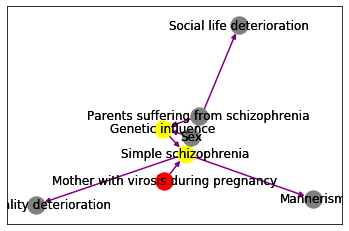



❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈ 

The node 'Simple schizophrenia' has Markov blanket: ['Mannerism', 'Personality deterioration', 'Mother with virosis during pregnancy', 'Social life deterioration', 'Genetic influence'].




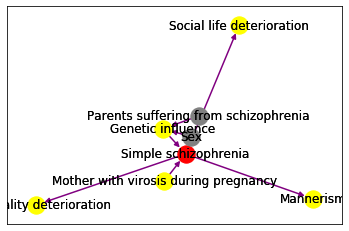



❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈ 

The node 'Parents suffering from schizophrenia' has Markov blanket: ['Sex', 'Genetic influence'].




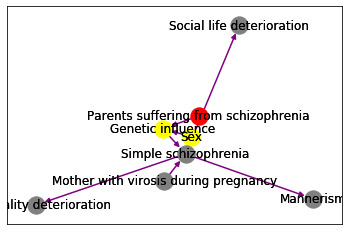



❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈ 

The node 'Genetic influence' has Markov blanket: ['Simple schizophrenia', 'Parents suffering from schizophrenia', 'Mother with virosis during pregnancy', 'Sex'].




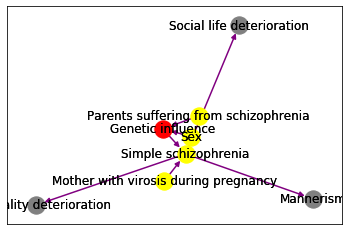



❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈ 

The node 'Sex' has Markov blanket: ['Parents suffering from schizophrenia', 'Genetic influence'].




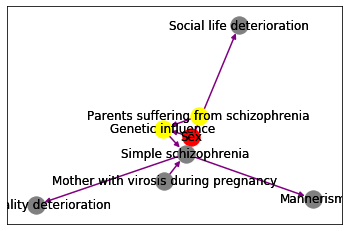



❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈ 



In [11]:
leaves = model.get_leaves()
markov_blanket = {}

for node in nodes:
    if not node in leaves:
        markov_blanket[node] = model.get_markov_blanket(node)
        print('The node \'{}\' has Markov blanket: {}.'.format(node, markov_blanket[node]))
        print('\n')
        
        nx.draw_networkx_nodes(DAG, pos, nodelist = [node], node_color = 'red')
        nx.draw_networkx_nodes(DAG, pos, nodelist = markov_blanket[node], node_color = 'yellow')
        nx.draw_networkx_nodes(DAG, pos, 
               nodelist = [n for n in nodes if n not in markov_blanket[node] and n != node], 
               node_color = 'grey')
        nx.draw_networkx_labels(DAG, pos)
        nx.draw_networkx_labels(DAG, pos)
        nx.draw_networkx_edges(DAG, pos, edge_color = 'purple', width = 1.5, arrows = True)
        plt.show()

        print('\n')
        print("❈"*85,"\n")

## 4. Queries
The basic task for any probabilistic inference system is to compute the posterior probability distribution for a set of **query variables**, given some observed event, that is some assignment of values to a set of **evidence values**.

### 4.1 Exact inference with variable elimination
The **variable elimination** is one of the most widespread method for exact inference. 
It's an improvement of the **inference by enumeration**, where the *repeated subexpression* of the query are evaluated only once (*dynamic programming*).

Different orderings of the variables cause different intermediate factors to be generated during the calculation, but every choice yields a valid algorithm.

In general, the time and space requirements of variable elimination are dominated by the size of the largest factor constructed during the operation of the algorithm. 
This in turn is determined by the order of elimination of variables and by the structure of the network.

It is intractable to determine the optimal ordering, but several good heuristics are available: 
* MinFill: the number of edges that need to be added to the graph due to its elimination;
* MinNeighbors: the number of neighbors it has in the current graph.
* MinWeight: the product of weights, domain cardinality, of its neighbors.
* WeightedMinFill: the sum of weights of the edges that need to be added to the graph due to its elimination, where a weight of an edge is the product of the weights, domain cardinality, of its constituent vertices.


In [12]:
exact_inference_variable_elimination = VariableElimination(model)

The absolute probability of having a simple schizophrenia is (fortunately) kinda low:

In [13]:
print('P(Simple schizophrenia)')
query1 = exact_inference_variable_elimination.query([simple_schizophrenia], show_progress = False);
print(query1)

P(Simple schizophrenia)
+-----------------------------+-----------------------------+
| Simple schizophrenia        |   phi(Simple schizophrenia) |
+=============================+=============================+
| Simple schizophrenia(True)  |                      0.0207 |
+-----------------------------+-----------------------------+
| Simple schizophrenia(False) |                      0.9793 |
+-----------------------------+-----------------------------+


By the way, if we start considering genetic causes and congenital issues, we will see that the probability will start to rise:

In [14]:
print('P(Simple schizophrenia|Genetic influence = True, Mother with virosis = True)')
query2 = exact_inference_variable_elimination.query([simple_schizophrenia], {genetic_influence : 'True', mother_with_virosis : 'True'}, show_progress = False);
print(query2)

P(Simple schizophrenia|Genetic influence = True, Mother with virosis = True)
+-----------------------------+-----------------------------+
| Simple schizophrenia        |   phi(Simple schizophrenia) |
+=============================+=============================+
| Simple schizophrenia(True)  |                      0.2500 |
+-----------------------------+-----------------------------+
| Simple schizophrenia(False) |                      0.7500 |
+-----------------------------+-----------------------------+


Two important variables involved in obtaining the probability of a disease is the genetic influence: patients sex and number of relatives diagnosed with the illness.
 
It is known that women are more liable to have or to develop a psychiatric disease than men. Also there is a chance of schizophrenia for those whose mothers had some kind of virosis during pregnancy.


In [15]:
print('P(Genetic influence)')
query3 = exact_inference_variable_elimination.query([genetic_influence], show_progress = False)
print(query3)

P(Genetic influence)
+--------------------------+--------------------------+
| Genetic influence        |   phi(Genetic influence) |
+==========================+==========================+
| Genetic influence(True)  |                   0.0157 |
+--------------------------+--------------------------+
| Genetic influence(False) |                   0.9843 |
+--------------------------+--------------------------+


In [16]:
print('P(Social life deterioration)')
query4 = exact_inference_variable_elimination.query([social_life_deterioration], show_progress = False)
print(query4)

P(Social life deterioration)
+------------------------------------+----------------------------------+
| Social life deterioration          |   phi(Social life deterioration) |
+====================================+==================================+
| Social life deterioration(Present) |                           0.1161 |
+------------------------------------+----------------------------------+
| Social life deterioration(Absent)  |                           0.8839 |
+------------------------------------+----------------------------------+


The probability of having a simple schizophrenia, given the virosis during the pregnancy, gets higher as the number of parents with schizophrenia gets higher.

That makes sense with the concept of familiarity of the disease.

In [17]:
print('P(Simple schizophrenia|Parents suffering from schizophrenia = Zero, Mother with virosis during pregnancy = True)')
query5a = exact_inference_variable_elimination.query([simple_schizophrenia], {parents : 'Zero', mother_with_virosis : 'True'}, show_progress = False)
print(query5a, "\n")

print('P(Simple schizophrenia|Parents suffering from schizophrenia = One, Mother with virosis during pregnancy = True)')
query5b = exact_inference_variable_elimination.query([simple_schizophrenia], {parents : 'One', mother_with_virosis : 'True'}, show_progress = False)
print(query5b, "\n")

print('P(Simple schizophrenia|Parents suffering from schizophrenia = Both, Mother with virosis during pregnancy = True)')
query5c = exact_inference_variable_elimination.query([simple_schizophrenia], {parents : 'Both', mother_with_virosis : 'True'}, show_progress = False)
print(query5c)

P(Simple schizophrenia|Parents suffering from schizophrenia = Zero, Mother with virosis during pregnancy = True)
+-----------------------------+-----------------------------+
| Simple schizophrenia        |   phi(Simple schizophrenia) |
+=============================+=============================+
| Simple schizophrenia(True)  |                      0.0817 |
+-----------------------------+-----------------------------+
| Simple schizophrenia(False) |                      0.9183 |
+-----------------------------+-----------------------------+ 

P(Simple schizophrenia|Parents suffering from schizophrenia = One, Mother with virosis during pregnancy = True)
+-----------------------------+-----------------------------+
| Simple schizophrenia        |   phi(Simple schizophrenia) |
+=============================+=============================+
| Simple schizophrenia(True)  |                      0.0893 |
+-----------------------------+-----------------------------+
| Simple schizophrenia(False)

As we inferred before, the local independencies for 'Genetic influence' are:

(Genetic influence ⟂ Mother with virosis during pregnancy | Sex, Parents suffering from schizophrenia).

Indeed, if, for example, we calculate:
* $P(\text{Genetic influence} | \text{Sex} = \text{Male}, \text{Parents suffering from schizophrenia} = \text{Zero}, \text{Mother with virosis during pregnancy} = \text{True})$

* $P(\text{Genetic influence} | \text{Sex} = \text{Male}, \text{Parents suffering from schizophrenia} = \text{Zero}, \text{Mother with virosis during pregnancy} = \text{False})$

we will have the same result, despite the virosis.

In [18]:
print('P(Genetic influence|Sex = Male, Parents suffering from schizophrenia = Zero, Mother with virosis during pregnancy = True)')
query6a = exact_inference_variable_elimination.query([genetic_influence], {sex : 'Male', parents : 'Zero', mother_with_virosis : 'True'}, show_progress = False)
print(query6a, "\n")

print('P(Genetic influence|Sex = Male, Parents suffering from schizophrenia = Zero, Mother with virosis during pregnancy = False)')
query6b = exact_inference_variable_elimination.query([genetic_influence], {sex : 'Male', parents : 'Zero', mother_with_virosis : 'False'}, show_progress = False)
print(query6b)

P(Genetic influence|Sex = Male, Parents suffering from schizophrenia = Zero, Mother with virosis during pregnancy = True)
+--------------------------+--------------------------+
| Genetic influence        |   phi(Genetic influence) |
+==========================+==========================+
| Genetic influence(True)  |                   0.0100 |
+--------------------------+--------------------------+
| Genetic influence(False) |                   0.9900 |
+--------------------------+--------------------------+ 

P(Genetic influence|Sex = Male, Parents suffering from schizophrenia = Zero, Mother with virosis during pregnancy = False)
+--------------------------+--------------------------+
| Genetic influence        |   phi(Genetic influence) |
+==========================+==========================+
| Genetic influence(True)  |                   0.0100 |
+--------------------------+--------------------------+
| Genetic influence(False) |                   0.9900 |
+------------------------

### 4.2 Approximate inference

In [19]:
''' Reference query for comparison'''
reference_query = exact_inference_variable_elimination.query([simple_schizophrenia], {sex : 'Female', mother_with_virosis : 'True'}, show_progress = False).values[1]
print('P(Simple schizophrenia = False|Sex = Female, Mother with virosis during pregnancy = True) = {}.'.format(reference_query))

P(Simple schizophrenia = False|Sex = Female, Mother with virosis during pregnancy = True) = 0.917212.


In [20]:
inference = BayesianModelSampling(model)

evidences = [State(sex, 'Female'), State(mother_with_virosis, 'True')]
verbose = False
sample_size = 10

def prob_LW(samples, variable):
    return round(np.sum(np.dot(samples[variable], samples['_weight']))/np.sum(samples['_weight']), 2)

def relative_error(exact_value, approx_value):
    return np.absolute((exact_value - approx_value)/exact_value)

def absolute_error(exact_value, approx_value):
    return np.absolute(exact_value - approx_value)

def run_experiment(sample_size):
    # Sample
    samples_LW = inference.likelihood_weighted_sample(evidence = evidences, 
                                                      size = sample_size, 
                                                      return_type = 'recarray')
    
    samples_RS = inference.rejection_sample(evidence = evidences, 
                                            size = sample_size, 
                                            return_type = 'recarray')
    
    # Statistics
    query_LW = prob_LW(samples_LW, simple_schizophrenia)
    query_RS = np.recarray.mean(samples_RS[simple_schizophrenia], axis = 0)

      
    # Return results
    return np.array([(sample_size, 
                      query_RS, absolute_error(reference_query, query_RS),
                      query_LW, absolute_error(reference_query, query_LW))],
                    dtype = [('sample_size', '<i8'), 
                             ('query_RS', '<f8'),('e_query_RS', '<f8'),
                             ('query_LW', '<f8'),('e_query_LW', '<f8')])

In [21]:
results = np.array([], dtype = [('sample_size', '<i8'), 
                                ('query_RS', '<f8'), ('e_query_RS', '<f8'),
                                ('query_LW', '<f8'), ('e_query_LW', '<f8')])

starting_size_ = 1 
final_size = 5    
experiments = 10

for size in np.logspace(starting_size_, final_size, num = experiments, dtype = '<i8'):
    results = np.append(results, run_experiment(size))
    
print(results)

c:\users\wxw85\appdata\local\programs\python\python37\lib\site-packages\pgmpy\factors\discrete\DiscreteFactor.py:519: UserWarning: Found unknown state name. Trying to switch to using all state names as state numbers
  "Found unknown state name. Trying to switch to using all state names as state numbers"
Generating for node: Sex:   0%|                                                                  | 0/8 [00:00<?, ?it/s]
Generating for node: Parents suffering from schizophrenia:   0%|                                 | 0/8 [00:00<?, ?it/s]
Generating for node: Genetic influence:   0%|                                                    | 0/8 [00:00<?, ?it/s]
Generating for node: Mother with virosis during pregnancy:   0%|                                 | 0/8 [00:00<?, ?it/s]
Generating for node: Personality deterioration: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 276.61it/s]

Generating for node: Sex:   0%|                                                               

[(    10, 1.        , 0.082788  , 0.8 , 0.117212)
 (    27, 0.88888889, 0.02832311, 0.81, 0.107212)
 (    77, 0.90909091, 0.00812109, 0.86, 0.057212)
 (   215, 0.92093023, 0.00371823, 0.93, 0.012788)
 (   599, 0.91819699, 0.00098499, 0.92, 0.002788)
 (  1668, 0.91486811, 0.00234389, 0.93, 0.012788)
 (  4641, 0.91531997, 0.00189203, 0.92, 0.002788)
 ( 12915, 0.91746032, 0.00024832, 0.92, 0.002788)
 ( 35938, 0.91813679, 0.00092479, 0.92, 0.002788)
 (100000, 0.91658   , 0.000632  , 0.92, 0.002788)]


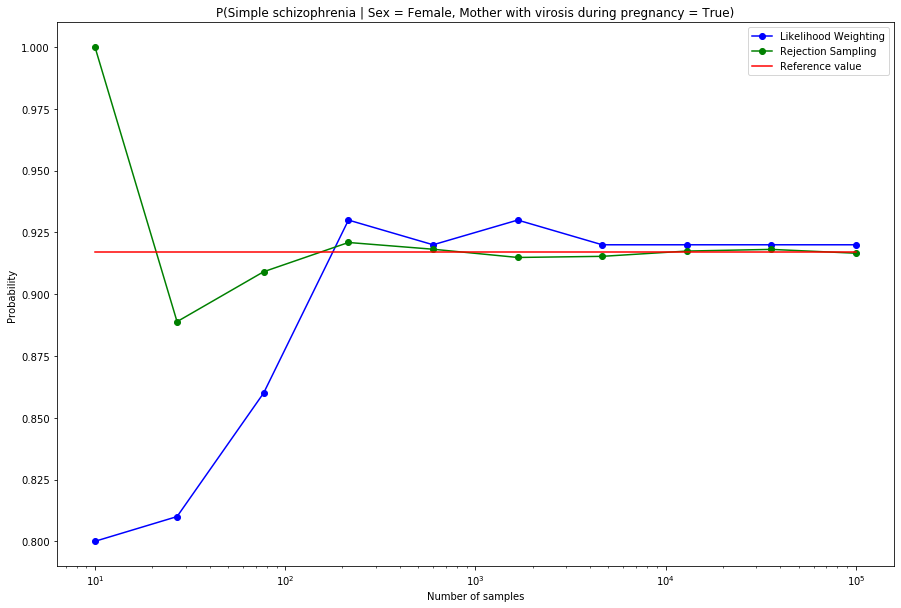

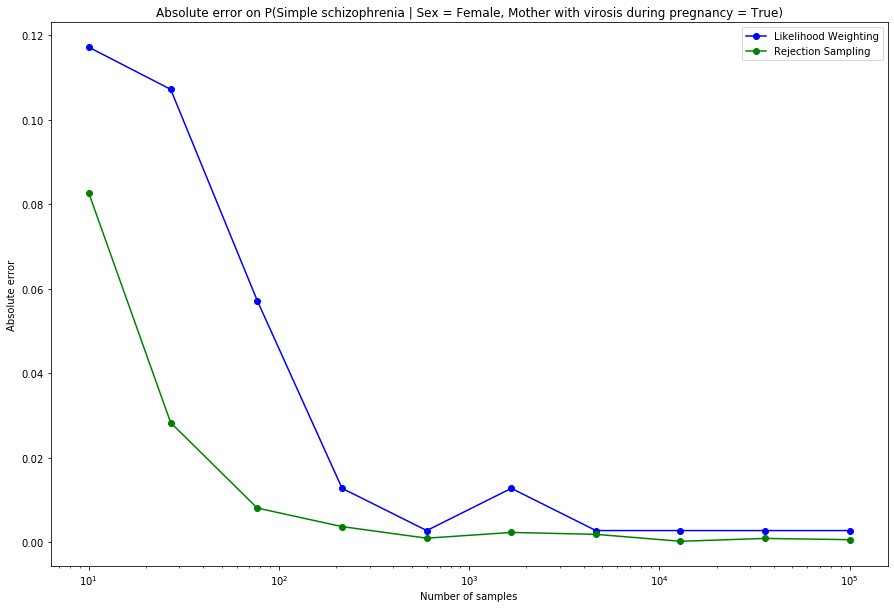

In [22]:
''' Comparison '''
plt.figure(figsize = (15, 10))
# Plot 1

plt.xlabel("Number of samples")
plt.ylabel("Probability")
plt.title(f'P({simple_schizophrenia} | {sex} = Female, {mother_with_virosis} = True)')
LWCplot, = plt.semilogx(results['sample_size'],
                        results['query_LW'],
                        '-bo',
                        label = "Likelihood Weighting")

RSCplot, = plt.semilogx(results['sample_size'],
                        results['query_RS'],
                        '-go',
                        label = "Rejection Sampling")

VECplot, = plt.semilogx(results['sample_size'],
                        reference_query*np.ones(results.size),
                        'r',
                        label = "Reference value")

plt.legend(handles = [LWCplot, RSCplot, VECplot])

plt.show()
# Plot 2
plt.figure(figsize = (15, 10))

plt.xlabel("Number of samples")
plt.ylabel("Absolute error")
plt.title(f'Absolute error on P({simple_schizophrenia} | {sex} = Female, {mother_with_virosis} = True)')
ELWCplot, = plt.semilogx(results['sample_size'],
                         results['e_query_LW'],
                         'bo-',
                         label = "Likelihood Weighting")

ERSCplot, = plt.semilogx(results['sample_size'],
                         results['e_query_RS'],
                         'go-',
                         label = "Rejection Sampling")

plt.legend(handles = [ELWCplot, ERSCplot])

plt.show()

As we can see from the graphs, the approximate inference method converges to the reference value after a certain number of samples.  
In our study case, the approximate method is not very useful since the developed model is kinda small, so the exact inference method is very fast.

## 5. Conclusion and future developments

During the development of the model, due to the lack of data, we could not develop the whole network proposed by the paper, but only a subgraph, whose data were present in the paper.
  
Indeed, one of the future development could be the collection of the missing data and implement all other nodes, making this network more compliant for diagnosis purposes.

Then, we can also inquire more specifically about the type of causes, such as the timing of the virosis, and how they influence other nodes: could we use a continuous variable or a discrete to represents time? Can different types of virus influence the probability of other nodes as well? Does it depend on the RNA or DNA basis?.


